# XBeach Wave boundary

Demo notebook with usage examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

In [3]:
datadir = Path("../../../rompy-xbeach/tests/data")
outdir = Path("wave-boundary-demo")
outdir.mkdir(exist_ok=True, parents=True)

## Overview

XBeach wave boundary objects provide an interface to generate wave boundary conditions
from existing data.


### 1. Input data

#### 1.1. Input data structure

Two types of data structure are supported:

* **Gridded data**: The data are gridded over the (x, y) space. This type of data
usually includes integraged parameters but it is also possible to have gridded wave
spectra (e.g., ERA5 output).

* **Station data**: The data are defined with a single "station-type" dimension which
has associated variables to define the (x, y) coordinates of each station point.
Wavespectra are typically specified with this structure but wave parameters can also be
provided that way (e.g., SMC output).

#### 1.2. Input data type

Two types of data type are supported. These types may be specified from gridded and
station data structures.

* **Frequency-direction wave spectra**: Prescribe wave boundary conditions from the
full spectra

* **Integrated wave parameters**: Prescribe wave boundary conditions from integrated
wave parameters


### 2. XBeach `bctype`

XBeach can be run off wave spectra or wave parameters. The model uses the `bctype`
parameter to receive different types of wave boundary data.


### 3. Rompy-XBeach interface

The interface in rompy-xbeach allow constructing different `bctype` options from the
supported range of input data structures and data types. Each object is defined as
follows:

`Boundary{Data-structure}{Data-type}{Bctype}`

For example, the `BoundaryStationSpectraJons` interface deals with `station`, 2D
`spectra` data and produces `jons` bctype.

## Interfaces

XBeach boundary interfaces are intantiated with a `Source` instance plus some parameters
that are specific to each input data and bctype. They all have a `get()` method which
takes as inputs the workspace `destdir` directory, the model `grid`, and the model `time`.
The source data are sliced at the location of the offshore boundary, defined from the grid,
and over the model times. The sliced data is used to create XBeach `bcfile` data. The
method returns a dictionary with the key-value pair to write in the XBeach params file.

Let's start off by defining some input source, time and grid objects to use with
the different boundary objects. The `spectra` and `param` prefixes indicate objects to
use with boundary objects based on spectra and integrated parameters data, respectively

In [4]:
from rompy.core.time import TimeRange
from rompy_xbeach.grid import RegularGrid
from rompy_xbeach.source import SourceCRSWavespectra
from rompy_xbeach.source import SourceCRSFile

In [5]:
# Data source
source_spectra = SourceCRSWavespectra(
    uri=datadir / "aus-20230101.nc",
    reader="read_ww3",
)
source_param = source = SourceCRSFile(
    uri=datadir / "smc-params-20230101.nc",
    crs=4326,
    x_dim="lon",
    y_dim="lat",
)

# Model times
times_spectra = TimeRange(start="2023-01-01T00", end="2023-01-01T12", interval="1h")
times_param = TimeRange(start="2023-01-01T00", end="2023-01-01T03", interval="1h")

# Model grid
grid = RegularGrid(
    ori=dict(x=115.594239, y=-32.641104, crs="epsg:4326"),
    alfa=347.0,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

## jons bctype

### BoundaryStationSpectraJons

XBeach jonswap type wave boundary from station spectra input data

In [6]:
from rompy_xbeach.boundary import BoundaryStationSpectraJons

#### Multiple bcfiles


By default, multiple bcfiles with the associated filelist file are generated if the
multiple time steps are available in the source data within the time range provided.
This behaviour is controlled by the `filelist` parameter which defaults to True`.

In [7]:
destdir = outdir / "jons_multi"
destdir.mkdir(exist_ok=True)

# The filelist parameter indicates one bcfile will be generated for each time step and
# a filelist file will be generated with the list of bcfiles. The coords parameter is
# usually not needed for wavespectra type sources since wavespectra datasets have
# established conventions for the coordinates. The dbtc parameter is specific to the
# Jons bctype and defines the internal XBeach timestep of the generated wave timeseries. 

wb = BoundaryStationSpectraJons(
    source=source_spectra,
    filelist=True, # this is the default value
    coords=dict(x="lon", y="lat", s="site"), # this is the default value
    dbtc=2.0, # timestep of the generated wave timeseries, ignore it to let xbeach decide
    fnyq=0.3, # Nyquist frequency, ignore it to let xbeach decide
    dfj=None, # step size frequency for the Jonswap spectrum, ignore it to let xbeach decide
)

# Generate the XBeach boundary files and return the list of bcfiles

namelist = wb.get(destdir=destdir, grid=grid, time=times_spectra)
namelist

{'wbctype': 'jons', 'bcfile': 'jons-filelist.txt'}

In [8]:
# The jons-filelist.txt is created in the destdir directory and contains the list of
# bcfiles which are also created in the same workspace. One file is created for each
# time step in the input source data within the time period specified in the time
# parameter (the initial and end times are interpolated at time.start and time.end if
# these exact times are not present in the source dataset).

list(destdir.glob("*.txt"))

[PosixPath('wave-boundary-demo/jons_multi/jons-20230101T000000.txt'),
 PosixPath('wave-boundary-demo/jons_multi/jons-20230101T060000.txt'),
 PosixPath('wave-boundary-demo/jons_multi/jons-filelist.txt')]

In [9]:
# Let's inspect the content of bcfile. Note the duration is defined by the
# time steps in the source dataset which in this test data file is 6h.

filelist = destdir / namelist["bcfile"]
print(filelist.read_text())

FILELIST
21600 2 jons-20230101T000000.txt
21600 2 jons-20230101T060000.txt



In [10]:
# And the content of one of the bcfiles

bcfile = destdir / filelist.read_text().split("\n")[1].split()[-1]
print(bcfile.read_text())

s = 66.9335
Hm0 = 0.451453
mainang = 44.6871
fnyq = 0.3
Tp = 14.3738
gammajsp = 2.37594



#### Single bcfile

If the `filelist` parameter is set to `False`, a single `bcfile` is created at `time.start`
and used to run the entire simulation period.

In [11]:
destdir = outdir / "jons_single"
destdir.mkdir(exist_ok=True)

# Single bcfile at time.start
wb = BoundaryStationSpectraJons(
    source=source_spectra,
    filelist=False
)

# Generate the XBeach boundary file
namelist = wb.get(destdir=destdir, grid=grid, time=times_spectra)
namelist

{'wbctype': 'jons', 'bcfile': 'jons-20230101T000000.txt'}

In [12]:
# The filelist file is not created in the workspace, only one single bcfile

workspace_files = list(destdir.glob("*.txt"))
workspace_files

[PosixPath('wave-boundary-demo/jons_single/jons-20230101T000000.txt')]

In [13]:
print(workspace_files[0].read_text())

s = 66.9335
Hm0 = 0.451453
mainang = 44.6871
Tp = 14.3738
gammajsp = 2.37594



### BoundaryStationParamJons

XBeach jonswap type wave boundary from station parameters input data

In [14]:
from rompy_xbeach.boundary import BoundaryStationParamJons

#### Multiple bcfiles

In [15]:
# Destination directory
destdir = outdir / "param_jons_multi"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wb = BoundaryStationParamJons(
    source=source_param,
    coords=dict(s="seapoint", x="longitude", y="latitude", t="time"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
namelist = wb.get(destdir=destdir, grid=grid, time=times_param)
namelist

{'wbctype': 'jons', 'bcfile': 'jons-filelist.txt'}

In [16]:
sorted(destdir.glob("*.txt"))

[PosixPath('wave-boundary-demo/param_jons_multi/jons-20230101T000000.txt'),
 PosixPath('wave-boundary-demo/param_jons_multi/jons-20230101T010000.txt'),
 PosixPath('wave-boundary-demo/param_jons_multi/jons-20230101T020000.txt'),
 PosixPath('wave-boundary-demo/param_jons_multi/jons-filelist.txt')]

In [17]:
filelist = destdir / namelist["bcfile"]
print(filelist.read_text())

FILELIST
3600 1 jons-20230101T000000.txt
3600 1 jons-20230101T010000.txt
3600 1 jons-20230101T020000.txt



#### Single bcfile

In [18]:
# Destination directory
destdir = outdir / "param_jons_single"
destdir.mkdir(exist_ok=True)

wb = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"), # all other coordinates are equal to the default values
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
namelist = wb.get(destdir=destdir, grid=grid, time=times_param)
namelist

{'wbctype': 'jons', 'bcfile': 'jons-20230101T000000.txt'}

In [19]:
workspace_files = list(destdir.glob("*.txt"))
workspace_files

[PosixPath('wave-boundary-demo/param_jons_single/jons-20230101T000000.txt')]

In [20]:
print(workspace_files[0].read_text())

s = 21.9514
Hm0 = 0.875435
mainang = 254.158
Tp = 13.1659
gammajsp = 2.68225



#### Default parameters

Fields `hm0`, `tp` and `mainang` are required in `BoundaryStationParamJons`. The other
parameters `gammajsp` and `dspr` are optional and defined internally by XBeach if not provided

In [21]:
wb = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
)

bcfile = wb.get(destdir=destdir, grid=grid, time=times_param)

print(workspace_files[0].read_text())

Hm0 = 0.875435
mainang = 254.158
Tp = 13.1659



Alternatively, it is possible to define any of the jonswap parameters as a float value,
in which case that float is used to define the jonswap parameter in the bcfiles

In [22]:
wb = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    dspr=20.0,
    gammajsp=3.0,
)

bcfile = wb.get(destdir=destdir, grid=grid, time=times_param)

print(workspace_files[0].read_text())

s = 15.414
Hm0 = 0.875435
mainang = 254.158
Tp = 13.1659
gammajsp = 3



Notice `BoundaryStationParamJons` takes the directional wave spreading `dspr` as input,
in degrees, which is the parameter usually available from spectral wave models - the
Jonswap spreading coefficient `s` is calculated from that parameter

## jonstable bctype

### BoundaryStationSpectraJonstable

XBeach jonswap table type wave boundary from station spectra input data

In [23]:
from rompy_xbeach.boundary import BoundaryStationSpectraJonstable

In [24]:
destdir = outdir / "jonstable_spectra"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wb = BoundaryStationSpectraJonstable(
    source=source_spectra,
)

# Generate the XBeach boundary file
namelist = wb.get(destdir=destdir, grid=grid, time=times_spectra)
namelist

{'wbctype': 'jonstable',
 'bcfile': 'jonstable-20230101T000000-20230101T120000.txt'}

In [25]:
filename = destdir / namelist["bcfile"]
print(filename.read_text())

0.451453 14.3738 44.6871 2.37594 66.9335 21600 1
0.472394 14.4435 44.6857 2.45055 90.0861 21600 1
0.490301 14.2813 44.7835 2.38401 48.2725 21600 1



### BoundaryStationParamJonstable

XBeach jonswap table type wave boundary from station parameters input data

In [26]:
from rompy_xbeach.boundary import BoundaryStationParamJonstable

In [27]:
destdir = outdir / "jonstable_param"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wb = BoundaryStationParamJonstable(
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
namelist = wb.get(destdir=destdir, grid=grid, time=times_param)
namelist

{'wbctype': 'jonstable',
 'bcfile': 'jonstable-20230101T000000-20230101T030000.txt'}

In [28]:
filename = destdir / namelist["bcfile"]
print(filename.read_text())

0.875435 13.1659 254.158 2.68225 21.9514 3600 1
0.909496 13.1292 254.18 2.71106 22.1417 3600 1
0.802303 14.8497 258.658 3.33514 37.515 3600 1
0.869525 14.4893 258.572 3.04059 32.5684 3600 1



## SWAN bctype

### BoundaryStationSpectraSwan

XBeach SWAN 2D spectra type wave boundary from station spectra input data

In [29]:
from wavespectra import read_swan

from rompy_xbeach.boundary import BoundaryStationSpectraSwan

#### Single bcfile

In [30]:
destdir = outdir / "swan_spectra_single"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wb = BoundaryStationSpectraSwan(
    source=source_spectra,
    filelist=False
)

# Generate the XBeach boundary file
namelist = wb.get(destdir=destdir, grid=grid, time=times_spectra)
namelist

{'wbctype': 'swan', 'bcfile': 'swan-20230101T000000.txt'}

In [31]:
filename = destdir / namelist["bcfile"]
dset = read_swan(filename)
dset

<xarray.Dataset> Size: 880B
Dimensions:  (time: 1, lat: 1, lon: 1, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-10-02T18:26:00
  * lat      (lat) float64 8B -32.63
  * lon      (lon) float64 8B 115.6
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, lat, lon, freq, dir) float64 704B 0.0001201 ... 1.863e-05

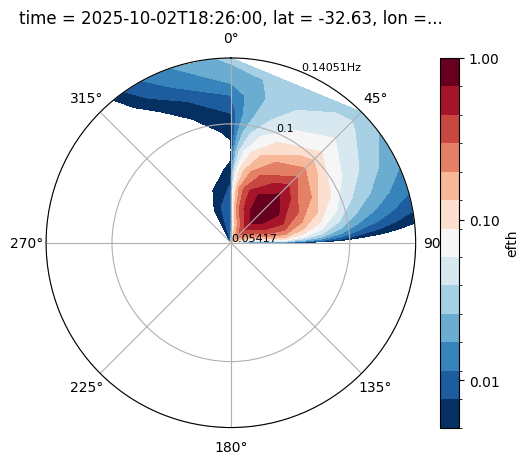

In [32]:
dset.squeeze().spec.plot()

#### Multiple bcfiles

In [33]:
destdir = outdir / "swan_spectra_multi"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wb = BoundaryStationSpectraSwan(
    source=source_spectra,
)

# Generate the XBeach boundary file
namelist = wb.get(destdir=destdir, grid=grid, time=times_spectra)
namelist

{'wbctype': 'swan', 'bcfile': 'swan-filelist.txt'}

In [34]:
sorted(destdir.glob("*.txt"))

[PosixPath('wave-boundary-demo/swan_spectra_multi/swan-20230101T000000.txt'),
 PosixPath('wave-boundary-demo/swan_spectra_multi/swan-20230101T060000.txt'),
 PosixPath('wave-boundary-demo/swan_spectra_multi/swan-filelist.txt')]

In [35]:
filelist = destdir / namelist["bcfile"]
print(filelist.read_text())

FILELIST
21600 1 swan-20230101T000000.txt
21600 1 swan-20230101T060000.txt



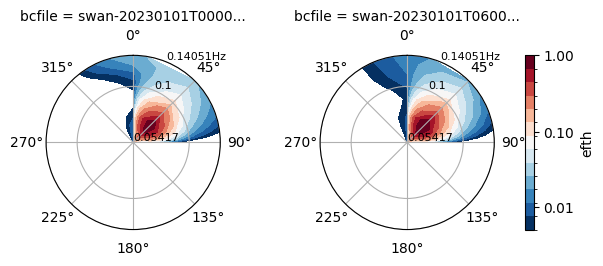

In [36]:
bcfiles = [row.split()[-1] for row in filelist.read_text().split("\n")[1:-1]]
dset = xr.concat([read_swan(destdir / f).squeeze() for f in bcfiles], dim="bcfile")
dset["bcfile"] = bcfiles
dset.spec.plot(col="bcfile")